In [16]:
!pip install qiskit
!pip install torchvision

In [0]:
from qiskit import *
import numpy as np

In [3]:
import torch
from torch.autograd import Function

class myExp(Function):
     @staticmethod
     def forward(ctx, i):
         result = i.exp()
         ctx.save_for_backward(result)
         return result

     @staticmethod
     def backward(ctx, grad_output):
         result, = ctx.saved_tensors
         return grad_output * result

x = torch.tensor([[1., -1.], [1., 1.]], requires_grad=True)
myexp = myExp.apply
y1 = x**2
y2 = myexp(y1).sum().backward()
x.grad

tensor([[ 5.4366, -5.4366],
        [ 5.4366,  5.4366]])

In [4]:
np.ones(1)

array([1.])

In [0]:
import numpy as np

In [6]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import matplotlib.pyplot as plt
%matplotlib inline

parameters = np.random.rand(3)
shots = 1000

circuit = QuantumCircuit(2, 2)

def add_measurements(circuit):
    nr_qubits = circuit.n_qubits
    circuit.measure(range(nr_qubits), range(nr_qubits))
    return circuit
    
def add_x_rotation(circuit):
    nr_qubits = circuit.n_qubits
    for i in range(nr_qubits):
        circuit.rx(np.pi/2, i)
    return circuit    

def add_y_rotation(circuit):
    nr_qubits = circuit.n_qubits
    for i in range(nr_qubits):
        circuit.ry(np.pi/2, i)  
    return circuit    

def execute_job(circuit, shots):
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(circuit, simulator, shots=shots)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

def N_qubit_expectation(circuit, shots, measurement='Z'):
    if measurement=='Z':
        print("Measure in Z")
        nr_qubits = circuit.n_qubits
        circuit = add_measurements(circuit)
        counts = execute_job(circuit, shots)
        return N_qubit_expectation_Z(counts, shots, nr_qubits)
    if measurement=='X':
        print("Measure in X")
        nr_qubits = circuit.n_qubits
        circuit = add_x_rotation(circuit)
        #circuit.h(0)
        circuit = add_measurements(circuit)
        counts = execute_job(circuit, shots)
        return N_qubit_expectation_Z(counts, shots, nr_qubits), circuit
    if measurement=='Y':
        nr_qubits = circuit.n_qubits
        circuit = add_y_rotation(circuit)
        circuit = add_measurements(circuit)
        counts = execute_job(circuit, shots)
        return N_qubit_expectation_Z(counts, shots, nr_qubits)
    else:
        print("Measurement type not yet defined")

def N_qubit_expectation_Z(counts, shots, nr_qubits):
    expects = np.zeros(nr_qubits)
    for key in counts.keys():
        perc = counts[key]/shots
        check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
        expects += check   
    return expects    

def one_qubit_expectation_Z(counts, shots):
    probs = sorted([(i, c/shots) for i, c in counts.items()])
    P = np.float64(np.array(probs)[:, 1])
    print(P[0], P[1])
    return P[0]*1 + P[1]*-1
    
def one_qubit_error(counts, shots, Z_traget):
    return (one_qubit_expectation_Z(counts, shots)- Z_target)**2

def N_qubit_error(counts, shots, nr_qubits, target_array):
    return ((N_qubit_expectation_Z(counts, shots, nr_qubits)-target_array)**2).sum()

#circuit = add_measurements(circuit)
#counts = execute_job(circuit, 1000)
expects, circuit = N_qubit_expectation(circuit, shots, measurement="X")
circuit.draw()
print(expects, circuit)

Measure in X
[-0.026  0.038]         ┌──────────┐┌─┐   
q_0: |0>┤ Rx(pi/2) ├┤M├───
        ├──────────┤└╥┘┌─┐
q_1: |0>┤ Rx(pi/2) ├─╫─┤M├
        └──────────┘ ║ └╥┘
 c_0: 0 ═════════════╩══╬═
                        ║ 
 c_1: 0 ════════════════╩═
                          


In [7]:
circuit.n_qubits

2

In [0]:
class QiskitCircuit():
    
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.phi = Parameter('Phi')
        self.lam = Parameter('Lambda')
        self.shots = shots
        
        def create_circuit():
            qr = QuantumRegister(1,'q')
            cr = ClassicalRegister(1,'c')
            ckt = QuantumCircuit(qr,cr)
            ckt.h(qr[0])
            ckt.barrier()
            ckt.u3(self.theta,self.phi,self.lam,qr[0])
            ckt.barrier()
            ckt.measure(qr,cr)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self,parameters):
        [self.theta,self.phi,self.lam] = parameters
        self.circuit.data[2][0]._params = parameters
        return self.circuit
    
    def run(self):
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=100000)
            
        ckt = ctx.QiskitCirc.bind([i[0][0].item(), i[0][1].item(), i[0][2].item()])
        exp_value = ctx.QiskitCirc.run()
        
        result = torch.tensor([[exp_value]])
        
        ctx.save_for_backward(result, i)
        
        print(result)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        eps = 0.01
        
        forward_tensor, i = ctx.saved_tensors    
        input_numbers = [i[0][0].item(), i[0][1].item(), i[0][2].item()]
        gradient = [0,0,0]
        
        for k in range(len(input_numbers)):
            input_eps = input_numbers
            input_eps[k] = input_numbers[k] + eps
            
            _ckt = ctx.QiskitCirc.bind(input_eps)

            exp_value = ctx.QiskitCirc.run()[0]
            result_eps = torch.tensor([[exp_value]])
            gradient_result = (exp_value - forward_tensor[0][0].item())
            gradient[k] = gradient_result
            
        result = torch.tensor([gradient])

        return result.float() * grad_output.float() 

In [0]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.optimization.ising import max_cut, tsp
from qiskit.aqua.algorithms.adaptive import VQE
from qiskit.aqua.algorithms import ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging

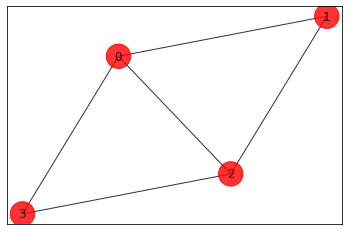

In [22]:
# Generating a graph of 4 nodes 

n=4 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

In [25]:
from docplex.mp.model import Model
from qiskit.optimization.ising import docplex

n=4

w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 
print(w)

qubitOp, offset = max_cut.get_max_cut_qubitops(w)
algo_input = EnergyInput(qubitOp)

mdl = Model(name='max_cut')
x = {i: mdl.binary_var(name='x_{0}'.format(i)) for i in range(n)}

# Object function
max_cut_func = mdl.sum(w[i,j]* x[i] * ( 1 - x[j] ) for i in range(n) for j in range(n))
mdl.maximize(max_cut_func)

# No constraints for Max-Cut problems.



qubitOp_docplex, offset_docplex = docplex.get_qubitops(mdl)




seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=1, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)
print(vqe.setting)

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

parameters = np.random.rand(8)
circuits = vqe.construct_circuit(parameters)
print(circuits[0])


algorithm_cfg = {'name': 'VQE'}
dictio = {'problem': {'name': 'ising'},'algorithm': algorithm_cfg}

vqe._energy_evaluation(parameters)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]
Algorithm: VQE
-- quantum_instance: None
-- var_form: <qiskit.aqua.components.variational_forms.ry.RY object at 0x7f609a6bf2e8>
-- optimizer: <qiskit.aqua.components.optimizers.spsa.SPSA object at 0x7f609a6bf7b8>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.adaptive.vqe.vqe.VQE object at 0x7f609a786278>>
-- initial_point: Random seed
-- parameterized_circuits: None
-- use_simulator_snapshot_mode: None
-- ret: None
-- eval_time: None
-- callback: None
-- operator: Representation: paulis, qubits: 4, size: 5
-- eval_count: 0
-- aux_operators: []
-- auto_conversion: True
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]', 'θ[3]', 'θ[4]', 'θ[5]', 'θ[6]', 'θ[7]']

        ┌─────────────────┐ ░                                               »
q_0: |0>┤ U3(0.52541,0,0) ├─░───────────────■───────────────────────────────»
        ├─────────────────┤ ░ ┌──────────┐┌─┴─┐┌──────────┐                 »
q_1: |0>┤ U

/usr/local/lib/python3.6/dist-packages/qiskit/optimization/ising/max_cut.py:136: DeprecationWarning: get_max_cut_qubitops function has been changed to get_operatorthe method here will be removed after Aqua 0.7+
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/qiskit/optimization/ising/docplex.py:286: DeprecationWarning: get_qubitops function has been changed to get_operator. The method here will be removed after Aqua 0.7+
  DeprecationWarning)


AttributeError: ignored

### MNIST in pytorch

In [24]:
import torch
import numpy as np
from torchvision import datasets, transforms

batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

torch.backends.cudnn.enabled = False

transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

labels = mnist_trainset.targets #get labels
labels = labels.numpy()
idx1 = np.where(labels == 0) #search all zeros
idx2 = np.where(labels == 1) # search all ones
idx = np.concatenate((idx1[0],idx2[0])) # concatenate their indices
mnist_trainset.targets = labels[idx] 
mnist_trainset.data = mnist_trainset.data[idx]

print(mnist_trainset)


train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=True)


NameError: ignored

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x)

In [0]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [0]:
epochs = 3
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    print(loss)

In [0]:
length = target.shape[0]
print(length)
for i in range(length):
    print(target[i], output[i][1])